# GuillaumeNet

This is a implementation of http://arxiv.org/pdf/1511.00561v2.pdf (Except for the Upsampling layer where paper uses indices based upsampling which is not implemented in keras yet( *I am working on it*), but that shouldnt make a lot of difference)


### variables globales

In [3]:
pathToDataset = '/home/traeze/mesdocs/daa'

### Setting Theano Flags

In [1]:
%matplotlib inline
import os
import cv2
from matplotlib import pyplot as plt


In [2]:
import numpy as np
np.random.seed(1337) # for reproducibility
from keras.layers.noise import GaussianNoise
import keras.models as models

from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense

from keras.layers.normalization import BatchNormalization
from keras.regularizers import ActivityRegularizer

from keras import backend as K

Using TensorFlow backend.


## Data Fetching 
I equalized histograms of rbg layers separately, so that change in lighting doesnt effect the results.

0
1
2
3
4
ok!


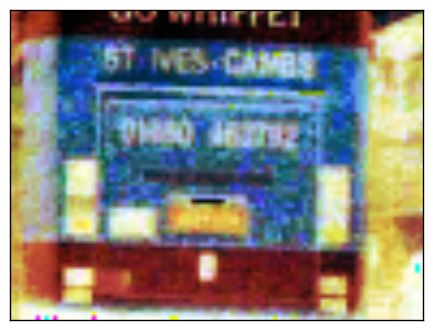

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 8 8 8 8 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]


In [8]:
path = './CamVid/'
data_shape = 360*480
window_size=(96,72) #format width*height
pad=15
width=480
height=360

def normalized(rgb):
    #return rgb/255.0
    norm=np.zeros((rgb.shape[0], rgb.shape[1], 3),np.float32)

    b=rgb[:,:,0]
    g=rgb[:,:,1]
    r=rgb[:,:,2]

    norm[:,:,0]=cv2.equalizeHist(b)
    norm[:,:,1]=cv2.equalizeHist(g)
    norm[:,:,2]=cv2.equalizeHist(r)

    return norm
   

def prep_data(start,end):
    train_data = []
    train_label = []
    
    with open(path+'train.txt') as f:
        txt = f.readlines()
        txt = [line.split(' ') for line in txt]
    for i in range(start,end):
        print(i)
        labels=cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0]
        for j in range(0,width-window_size[0],pad):
            for k in range(0,height-window_size[1],pad):
                w_labels = labels[k:k+window_size[1],j:j+window_size[0]]
                cl = [int(q) for q in w_labels.flatten()]
                cl = np.bincount(cl)
                cl= cl/np.sum(cl) # vecteur de probabilité de chaque classe ! et oué
                classe_dominante=np.argmax(cl) # probabilité d'appartenance à la classe dominante
                if(cl[classe_dominante]>.7):
                    img=cv2.imread(os.getcwd() + txt[i][0][7:])
                    window = img[k:k+window_size[1],j:j+window_size[0]] #fenetre glissante
                    train_data.append(normalized(window))
                    train_label.append(classe_dominante)
                    
    return np.array(train_data), np.array(train_label)

end=5
train_data, train_label = prep_data(0,end)
print("ok!")
plt.imshow(train_data[31])
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

print(train_label[1:50])

In [13]:

# class weigths
class_weighting= [0.2595, 0.1826, 4.5640, 0.1417, 0.9051, 0.3826, 9.6446, 1.8418, 6.6823, 6.2478, 3.0, 7.3614]


I am using custom Unpooling layer look here https://github.com/fchollet/keras/issues/1226 for the reason

### Creating and Compiling neuralnet

In [15]:
model = models.Sequential()
depth=3
height=360
width=480
classes=12

model.add(Convolution2D(10, 5, 5, border_mode="same",input_shape=(height, width,depth)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Convolution2D(10, 5, 5, border_mode="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(500))
model.add(Activation("relu"))
 
# softmax classifier
model.add(Dense(classes))
model.add(Activation("softmax"))
#from keras.optimizers import SGD
#optimizer = SGD(lr=0.01, momentum=0.8, decay=0., nesterov=False)
model.compile(loss="categorical_crossentropy", optimizer='adadelta')


Visualizing autoencoder

## Training 
At the end of 100 epochs training acc was about 0.91

#### Epoch 100/100

367/367 [==============================] - 890s - loss: 0.2942 - acc: 0.9100   


In [16]:
nb_epoch = 5
batch_size = 10

history = model.fit(train_data, train_label, batch_size=batch_size, nb_epoch=nb_epoch,
                    show_accuracy=True, verbose=1, class_weight=class_weighting)#, validation_data=(X_test, X_test))
model.save_weights('model_weights.hdf5')
#score = autoencoder.evaluate(X_test, X_test, show_accuracy=True, verbose=0)
#print('Test score:', score[0])
#print('Test accuracy:', score[1]) 

/home/eleves/soft/anaconda2/lib/python2.7/site-packages/keras/models.py:610: UserWarning: The "show_accuracy" argument is deprecated, instead you should pass the "accuracy" metric to the model at compile time:
`model.compile(optimizer, loss, metrics=["accuracy"])`
  warnings.warn('The "show_accuracy" argument is deprecated, '


Exception: Error when checking model target: expected activation_7 to have 2 dimensions, but got array with shape (10, 172800, 12)

### Visualization
I trained autoencoder sepeartely with 100 epochs, loading weights here.

In [11]:
model.load_weights('model_weight_ep100.hdf5')

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road_marking = [255,69,0]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

label_colours = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

def visualize(temp, plot=True):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0,11):
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    if plot:
        plt.imshow(rgb)
    else:
        return rgb

In [14]:
import os

gt = []
with open(path+'train.txt') as f:
    txt = f.readlines()
    txt = [line.split(' ') for line in txt]
for i in range(4):
    gt.append(cv2.imread(os.getcwd() + txt[i][0][7:]))

1/1 [==============================] - 9s


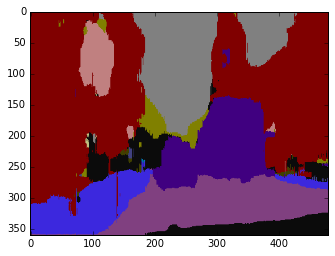

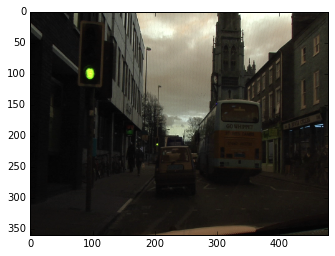

In [17]:
output = model.predict_proba(train_data[2:3])
pred = visualize(np.argmax(output[0],axis=1).reshape((360,480)), False)
plt.imshow(pred)
plt.figure(2)
plt.imshow(gt[2])